# ÖN HAZIRLIK - LAB-7
# Ad-Soyad: Batuhan Karaoğlu
# Numara: 171024089


In [1]:
import numpy as np
import scipy.signal as sgnl
import matplotlib.pyplot as plt
from scipy.fftpack import fft,ifft, fftshift, ifftshift
%matplotlib notebook

# Çalışma Soruları

### 2.1 Faz cevabı ve grup gecikmesi (Örnek2.ipynb)

<IPython.core.display.Javascript object>


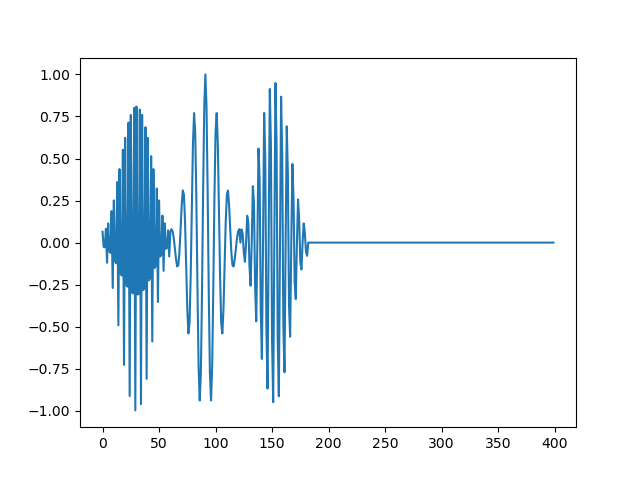

In [2]:
# WE NEED TO IMPORT THE CUSTOM (USER DEFINED) FUNCTION AS WELL, IN ORDER TO USE IT!!!
import SystemFunction

# Generate the individual components and the input signal
N = 400      # total number of samples in the input signal
M = 60       # size of the window function (and sample length of the frequency components)
n = np.arange(0, M+1, 1)   # index vector of M+1 points
wn = 0.54 - 0.46*np.cos(2*np.pi*n/M)      # window function (Hamming window)

# the components
x1 = wn*np.cos(0.2*np.pi*n)               # component with w1 = 0.2*pi frequency
x2 = wn*np.cos(0.4*np.pi*n - np.pi/2)     # component with w1 = 0.4*pi frequency
x3 = wn*np.cos(0.8*np.pi*n - np.pi/5)     # component with w1 = 0.8*pi frequency

xn = np.concatenate((x3, x1, x2, np.zeros(N-3*len(n))), axis=None)

plt.figure()
plt.plot(xn)
plt.show()

In [3]:
# Calculate the Fourier transform of xn
w = np.linspace(-np.pi, np.pi, N)
Xw = fft(xn)
Xw_shifted = np.fft.fftshift(Xw)

<IPython.core.display.Javascript object>


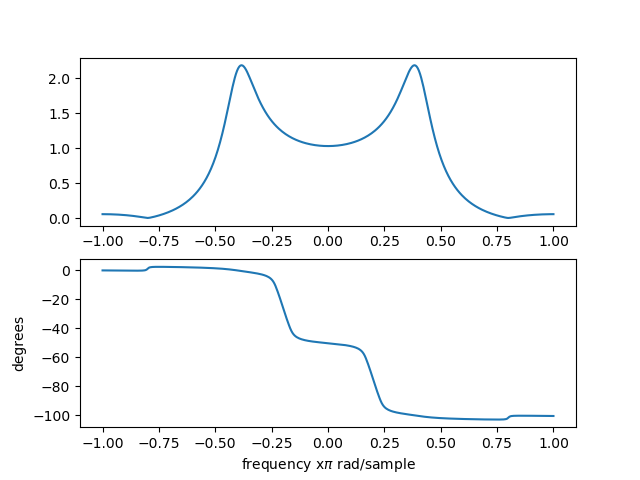

In [4]:
Hw, polezz, zerozz, K = SystemFunction.SystemFunction(w)

Hw_mag = abs(Hw)
Hw_phs = np.unwrap(np.angle(Hw))

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(w/np.pi, Hw_mag)
ax2.plot(w/np.pi, Hw_phs), plt.ylabel('degrees')
plt.xlabel('frequency x$\pi$ rad/sample')
plt.show()

By using the phase response, we calculate its group delay as follows.

Note the term  𝑁2𝜋  is necessary, when we calculate the group delay manually, to obtain correct unit of measurements. Otherwise, it is impossible to interpret the result.

<IPython.core.display.Javascript object>


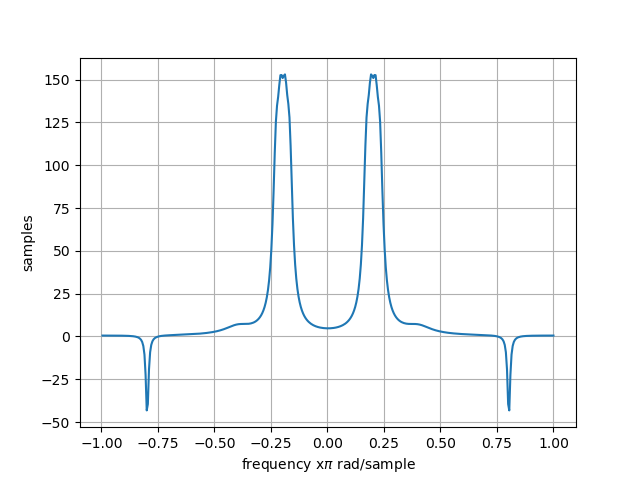

In [5]:
# calculate the group delay of the system:
tau_w = -np.diff(Hw_phs)*(N/(2*np.pi))
plt.figure()
plt.plot(w[1::]/np.pi, tau_w)
plt.ylabel('samples'), plt.xlabel('frequency x$\pi$ rad/sample')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


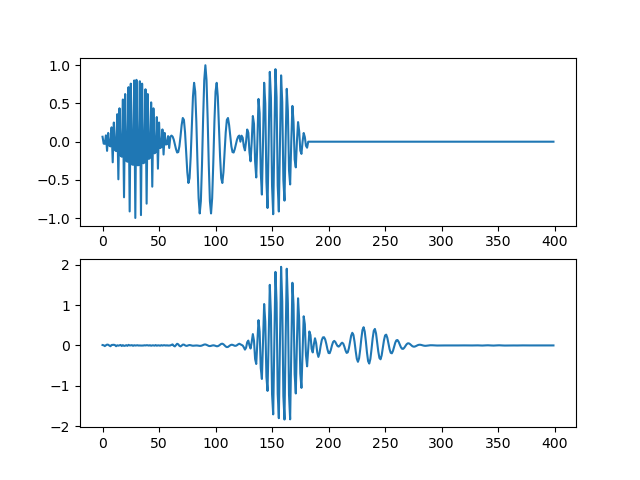

In [6]:
Yw_shifted = Hw * Xw_shifted          # we multiply the frequency response of the system with the **shifted** Fourier transform of the signal
Yw = np.fft.ifftshift(Yw_shifted)     # we shifted back to the 0-2*pi interval
yn = np.real(ifft(Yw))                # we calculate the inverse fft and take the real component (because of numerical consistency)

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(xn)
ax2.plot(yn)
plt.show()

Now we by looking at the input signal, frequency response of the system, and the output signal, we can analyze the the effect of the group delay on the signal. As can be seen in the last figure, components with different frequencies shifted different amounts of samples. The component with the lowest frequency ($0.2\pi$ rad/samples) shifted 150 samples. The component with $0.4\pi$ rad/samples shifted approx. 4 samples. Since the system suppressed the component with the highes frequency, it is not our concern anymore.

The obtained result, however, is problematic in most real-world (especially in real-time) applications. Because of the system, the signal is found to be distorted at the output. Consider the following analogy: you are playing a specific music part. You are playing several tones (input signal), however your instrument (i.e. the system) does not play the tunes in the correct order for some reason. Thus, it produces some nonsensical signal, which would be humiliating in front of an audience.

### 2.2 Lineer Fazlı FIR Filtreler (Örnek3.ipynb)

<IPython.core.display.Javascript object>


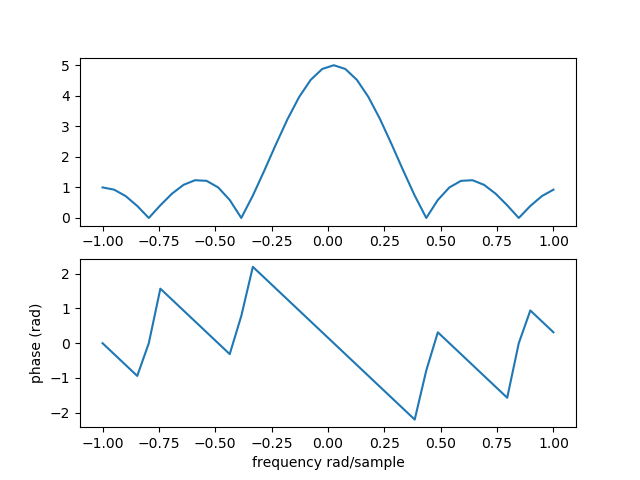

In [7]:
N = 40
hn = np.ones(5)
Hw = np.fft.fftshift(fft(hn, N))

w = np.linspace(-np.pi, np.pi, N)

Hw_mag = abs(Hw)
Hw_phs = np.unwrap(np.angle(Hw))

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(w/np.pi, Hw_mag)
ax2.plot(w/np.pi, Hw_phs), plt.ylabel('phase (rad)'), plt.xlabel('frequency rad/sample')
plt.show()

<IPython.core.display.Javascript object>


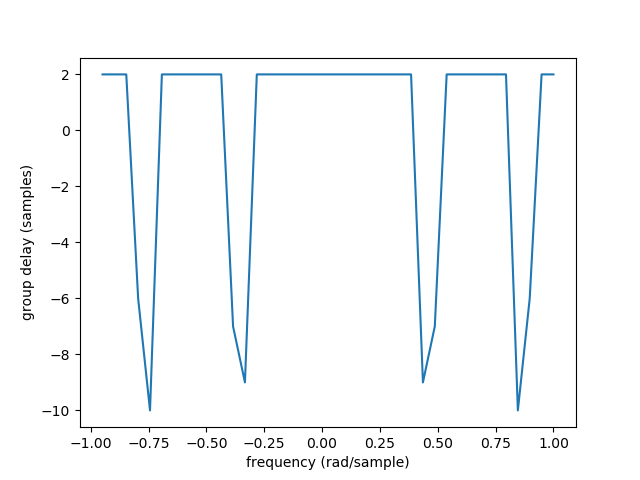

In [8]:
tau_w = -np.diff(Hw_phs)*(N/(2*np.pi))

plt.figure()
plt.plot(w[1::]/np.pi, tau_w)
plt.xlabel('frequency (rad/sample)')
plt.ylabel('group delay (samples)')
plt.show()

In [9]:
n = np.arange(0, N, 1)     # first create the index vector at N points
w0 = 0.1*np.pi             # frequency of the input signal
xn = np.cos(w0*n)          # create the input signal at w0

Xw = np.fft.fftshift(fft(xn, N))     # compute the frequency response (in the [-pi pi] interval)

Yw_shifted = Hw * Xw                 # compute the fft of the output signal
Yw = np.fft.ifftshift(Yw_shifted)    # we shifted back to the 0-2*pi interval
yn = np.real(ifft(Yw))

<IPython.core.display.Javascript object>


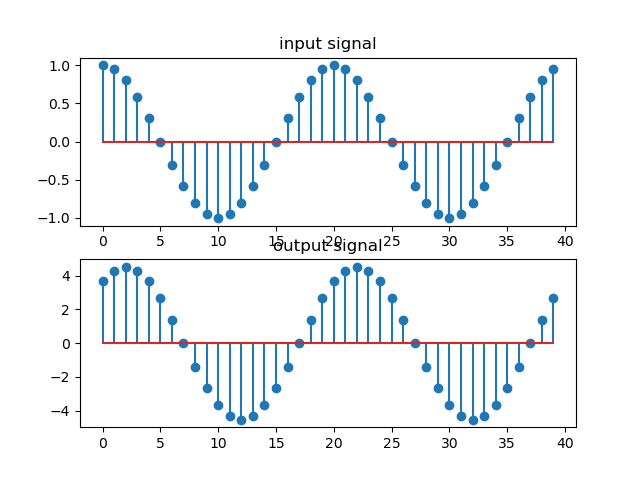

In [10]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.stem(n, xn, use_line_collection=True), ax1.title.set_text('input signal')
ax2.stem(n, yn, use_line_collection=True), ax2.title.set_text('output signal')
plt.show()

Now, by looking at the first peaks, we can confirm that, as we have predicted from the group delay, the output signal shifted exactly 2 samples with respect to the input. 

### 3. Filtre tasarlama (Örnek4.ipynb)

In [11]:
# to read .mat data file
from scipy.io import loadmat

We will use *scipy.io* library for loading .mat files. The following piece of code shows how to access the filter coefficients properly. Note that, if you import an IIR filter, both numerator and denominator coefficients exist. But, if you import an FIR filter, only numerator coefficients exist.

In [12]:
# importing an IIR filter
filter_data = loadmat('butterworth.mat')      # load the filter obtained from pyfda
Coeffs = filter_data['ba'].astype(np.float)   # get the coefficients and convert them to float (from string)

b = Coeffs[:,0]       # first column is b
a = Coeffs[:,1]       # second column is a (only if the filter is IIR)

<IPython.core.display.Javascript object>


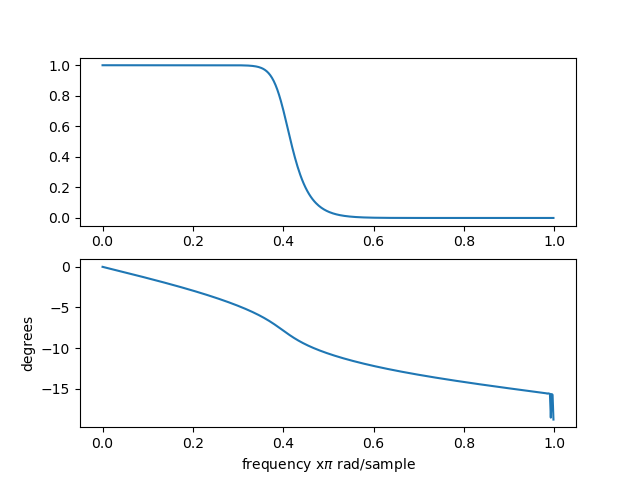

In [13]:
w, Hw = sgnl.freqz(b,a)

Hw_mag = abs(Hw)
Hw_phs = np.unwrap(np.angle(Hw))

fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(w/np.pi, Hw_mag)
ax2.plot(w/np.pi, Hw_phs), plt.ylabel('degrees')
plt.xlabel('frequency x$\pi$ rad/sample')
plt.show()

<IPython.core.display.Javascript object>


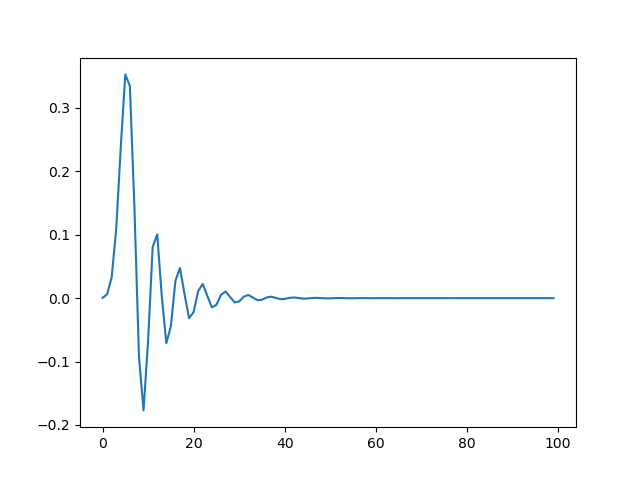

In [14]:
n, hn = sgnl.dimpulse((b,a,1), n=100)          # compute the impulse response for 100 points
plt.figure()
plt.plot(n, np.squeeze(hn))
plt.show()

<IPython.core.display.Javascript object>


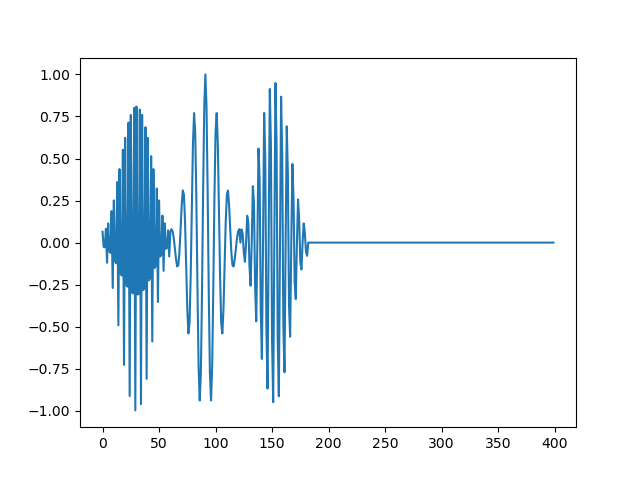

In [15]:
# Generate the individual components and the input signal
N = 400      # total number of samples in the input signal
M = 60       # size of the window function (and sample length of the frequency components)
n1 = np.arange(0, M+1, 1)   # index vector of M+1 points
wn = 0.54 - 0.46*np.cos(2*np.pi*n1/M)      # window function (Hamming window)

# the components
x1 = wn*np.cos(0.2*np.pi*n1)               # component with w1 = 0.2*pi frequency
x2 = wn*np.cos(0.4*np.pi*n1 - np.pi/2)     # component with w1 = 0.4*pi frequency
x3 = wn*np.cos(0.8*np.pi*n1 - np.pi/5)     # component with w1 = 0.8*pi frequency

xn = np.concatenate((x3, x1, x2, np.zeros(N-3*len(n1))), axis=None)

plt.figure()
plt.plot(xn)
plt.show()

<IPython.core.display.Javascript object>


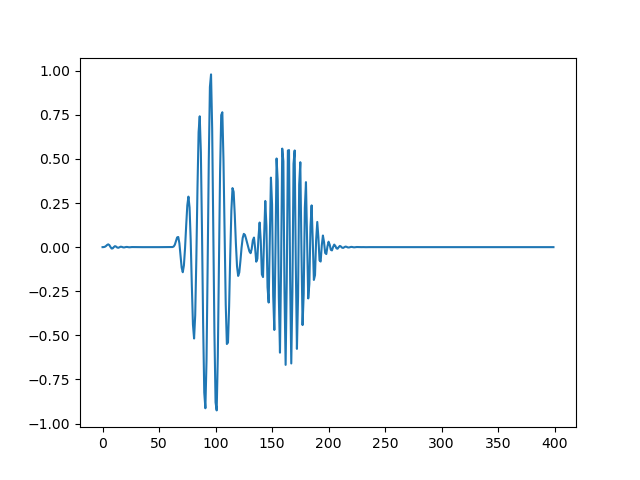

In [16]:
yn = sgnl.lfilter(b, a, xn)          # using the coefficients, we applied the signal to the input of the filter.

plt.figure()
plt.plot(yn)
plt.show()

# ÖN HAZIRLIK SORULARI
## SORU-1

In [17]:
pi = np.pi
N = 100
# IIR type(1 2 3 4) dürtü cevapları
h_type1 = np.array([1, 1, 1, 1, 1])
h_type2 = np.array([1, 1, 1, 1])
h_type3 = np.array([1, 1, 0, -1, -1])
h_type4 = np.array([1, 1, -1, -1])
# Fourier dönüşümleri
H_type1 = fft(h_type1, N) # 100 nokta olarak fft aldık.
H_type2 = fft(h_type2, N)
H_type3 = fft(h_type3, N)
H_type4 = fft(h_type4, N)
# Frekans eksenini tanımlayalım
w = np.arange(0, 2*pi, 2*pi/N)

In [18]:
# Genlik, Faz değerleri:
H_type1_abs = np.abs(H_type1); H_type1_angle = np.unwrap(np.angle(H_type1)) # faz değerlerini 2*pi tamamlayıcıları olarak
H_type2_abs = np.abs(H_type2); H_type2_angle = np.unwrap(np.angle(H_type2)) # ifade etmek için np.unwrap komutunu kullandık.
H_type3_abs = np.abs(H_type3); H_type3_angle = np.unwrap(np.angle(H_type3))
H_type4_abs = np.abs(H_type4); H_type4_angle = np.unwrap(np.angle(H_type4))
# Grup gecikmesi:
type1_tau = -np.diff(H_type1_angle)*(N/(2*pi))
type2_tau = -np.diff(H_type2_angle)*(N/(2*pi))
type3_tau = -np.diff(H_type3_angle)*(N/(2*pi))
type4_tau = -np.diff(H_type4_angle)*(N/(2*pi))

<IPython.core.display.Javascript object>


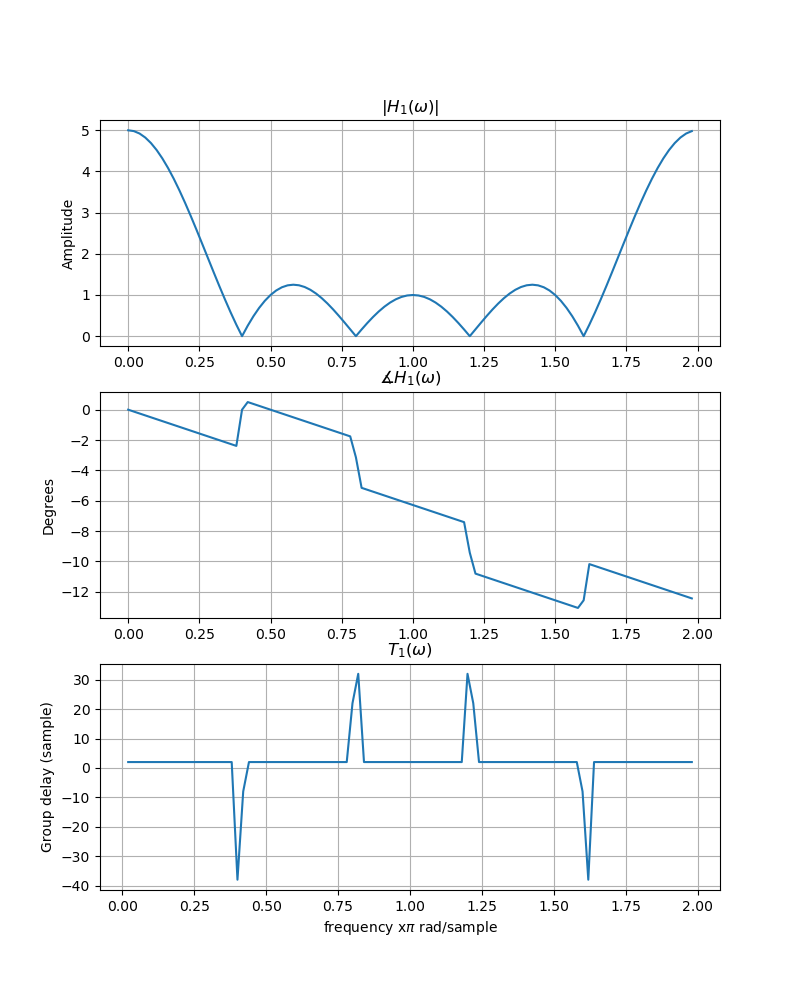

In [19]:
plt.figure("TYPE-I", figsize=(8,10))
plt.subplot(311)
plt.plot(w/pi, H_type1_abs); plt.title("$|H_{1}(\omega)|$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w/pi, H_type1_angle); plt.title("$\measuredangle H_{1}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w[1::]/pi, type1_tau); plt.title("$T_{1}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

<IPython.core.display.Javascript object>


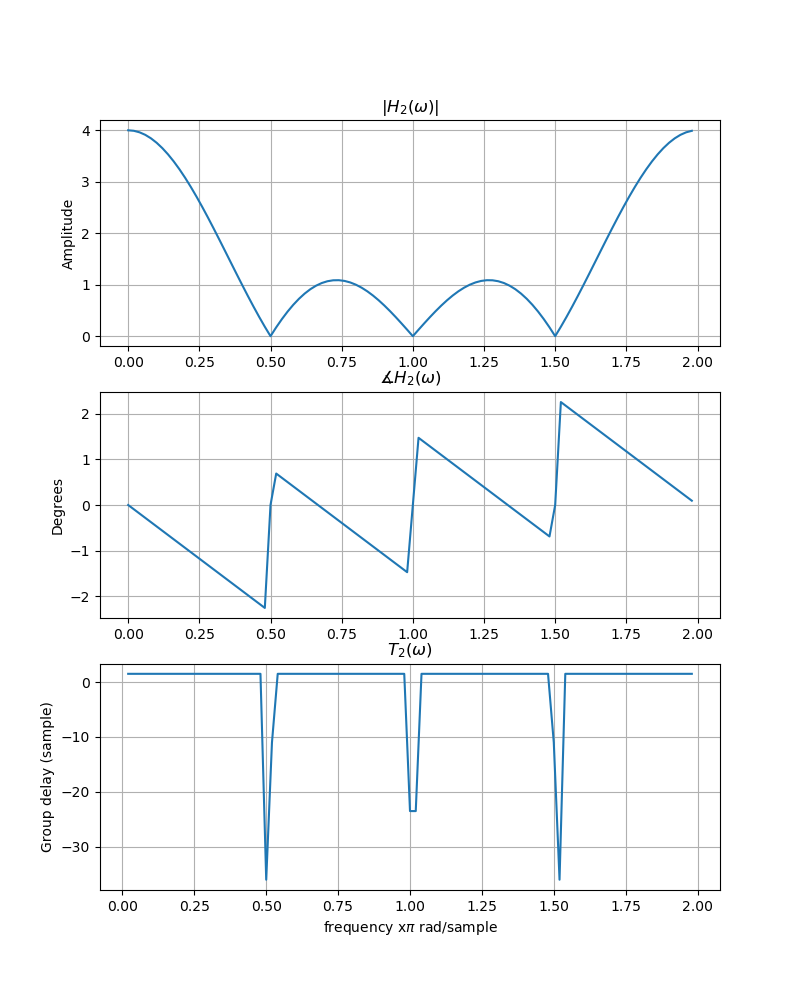

In [20]:
plt.figure("TYPE-II", figsize=(8,10))
plt.subplot(311)
plt.plot(w/pi, H_type2_abs); plt.title("$|H_{2}(\omega)|$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w/pi, H_type2_angle); plt.title("$\measuredangle H_{2}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w[1::]/pi, type2_tau); plt.title("$T_{2}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

<IPython.core.display.Javascript object>


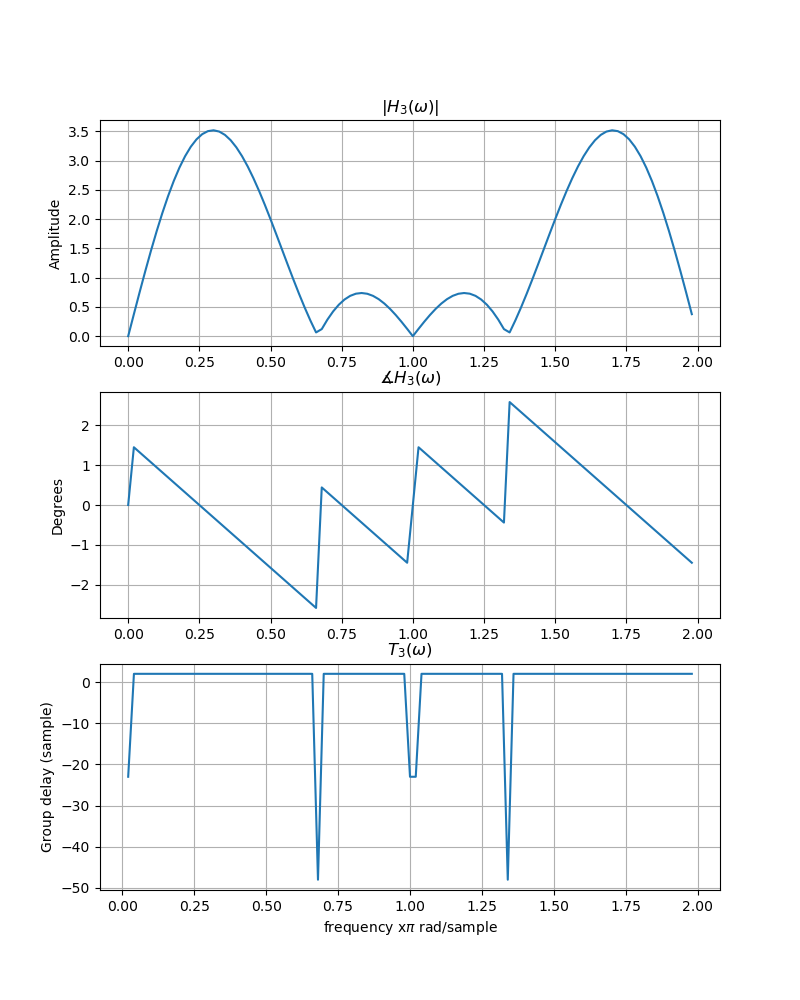

In [21]:
plt.figure("TYPE-III", figsize=(8,10))
plt.subplot(311)
plt.plot(w/pi, H_type3_abs); plt.title("$|H_{3}(\omega)|$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w/pi, H_type3_angle); plt.title("$\measuredangle H_{3}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w[1::]/pi, type3_tau); plt.title("$T_{3}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

<IPython.core.display.Javascript object>


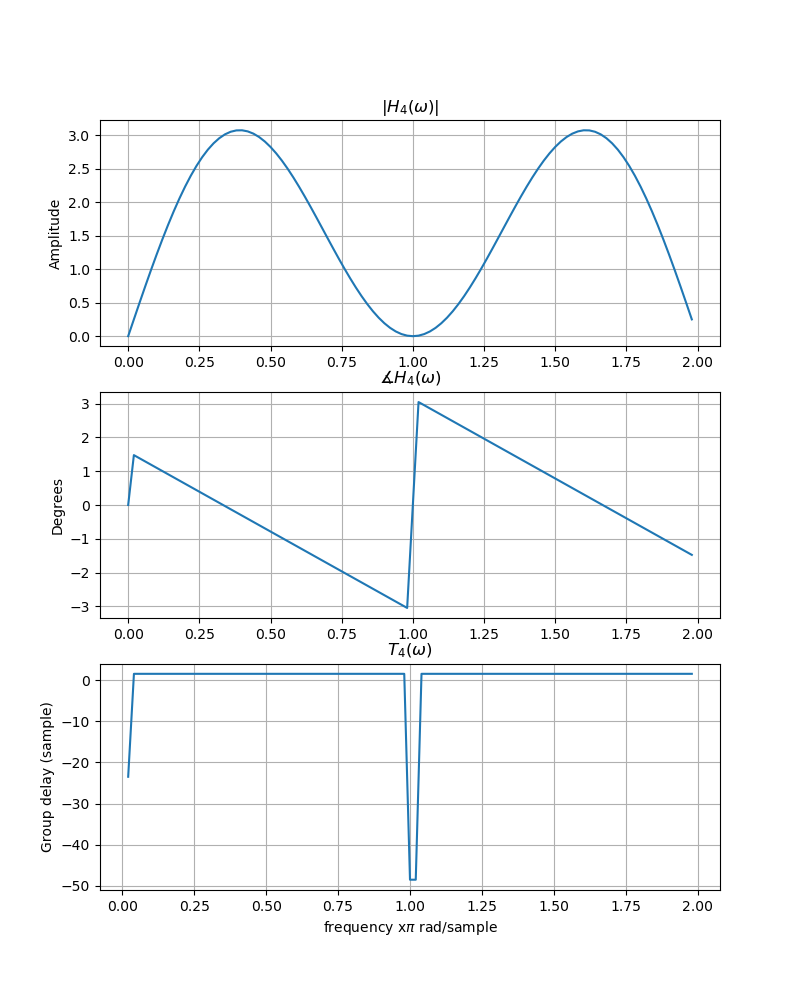

In [22]:
plt.figure("TYPE-IV", figsize=(8,10))
plt.subplot(311)
plt.plot(w/pi, H_type4_abs); plt.title("$|H_{4}(\omega)|$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w/pi, H_type4_angle); plt.title("$\measuredangle H_{4}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w[1::]/pi, type4_tau); plt.title("$T_{4}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

Grafiklere bakarak filtrelerin ne iş yaptığını tahmin edeceğiz:
 Öncelikle grafiği okurken, frekans uzayında birbirini $2\pi$'ye tamamlayan noktalar aynı değeri ifade etmektedir.Yani $[0,\pi]$ ve $[\pi,2\pi]$ aralığındaki değerler birbirinin ayna görüntüsüdür. Çünkü frekans uzayında en yüksek freakansımız $\pi$ olmaktadır. Grafikte filtre durumunu incelemek için  $[0,\pi]$ aralığına bakmamız yeterli olacaktır.
 
Öncelikle $|H_{Type-1}(\omega)|$ grafiğine bakarsak, alçak geçiren filtre gibi gözüktüğünü söyleyebiliriz. Genlik grafiğinde dözüktüğü üzere yaklaşık olarak $0.4\pi [^{rad}/_{sec}]$'a  kadar olan $\omega$ değerlerini geçirdiği diğer noktaları ise zayıflattığını söyleyebiliriz.

$|H_{Type-2}(\omega)|$ grafiğine bakarsak, type-2 FIR filtrenin de alçak geçiren filtre gibi gözüktüğünü söyleyebiliriz. Yine $[0,\pi]$ aralığını baz alırsak $\frac{\pi}{2}[^{rad}/_{sec}]$'dan önceki $\omega$ değerlerini geçirdiğini söyleyebiliriz. $\pi[^{rad}/_{sec}]$' a kadar olan frekansları ise zayıflatmaktadır.

$|H_{Type-3}(\omega)|$ grafiğine bakarsak, type-3 FIR filtrenin band geçiren filtre gibi gözüktüğünü söyleyebiliriz.

$|H_{Type-4}(\omega)|$ grafiğine bakarsak, type-4 FIR filtrenin band geçiren filtre gibi gözüktüğünü söyleyebiliriz.

4 tip FIR filtre için de, faz grafiklerine bakıldığında, genlik grafiğinin sürekli olduğu frekanslarda fazın doğrusal hareket ettiği gözlenmektedir. Sürekliliğin sağlandığı noktalarda bu grafikler lineer fazlıdır.

Aynı şekilde sürekliliğin sağlandığı frekans değerlerinde grup gecikmesi beklendiği üzere ise sabit sayı çıkmıştır. Süreklilik bulunan noktalarda bu filtreler sabit grup gecikmesine sahiptir.

<IPython.core.display.Javascript object>


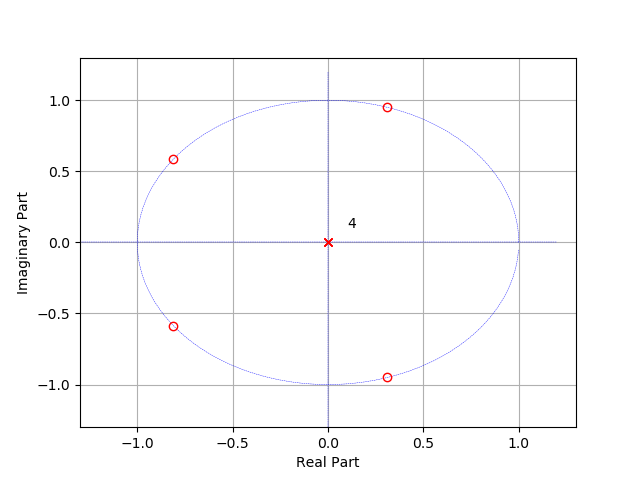

In [23]:
import zplane     # sistemler sonlu olduğu için payda kısmı 1'dir. ROC ise sonsuz hariç her yerdir.
### tip-1 için kutup-sıfır diyagramı
num1 = np.array([1,1,1,1,1])
denum1 = np.array([1])
zplane.zplane(num1, denum1)
plt.show()

<IPython.core.display.Javascript object>


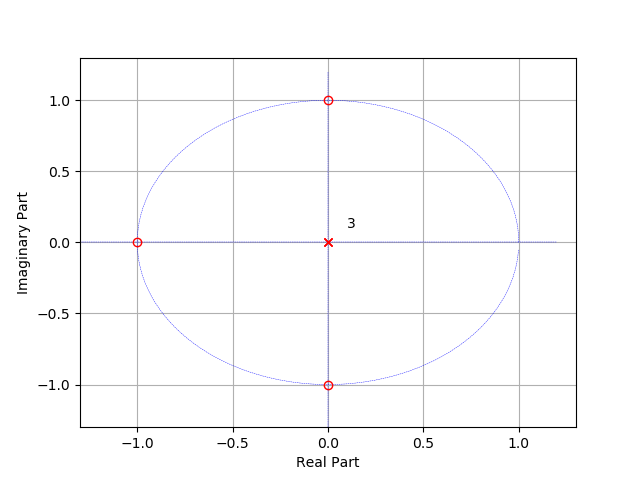

In [24]:
### tip-2 için kutup-sıfır diyagramı
num2 = np.array([1,1,1,1])
denum2 = np.array([1])
zplane.zplane(num2, denum2)
plt.show()

<IPython.core.display.Javascript object>


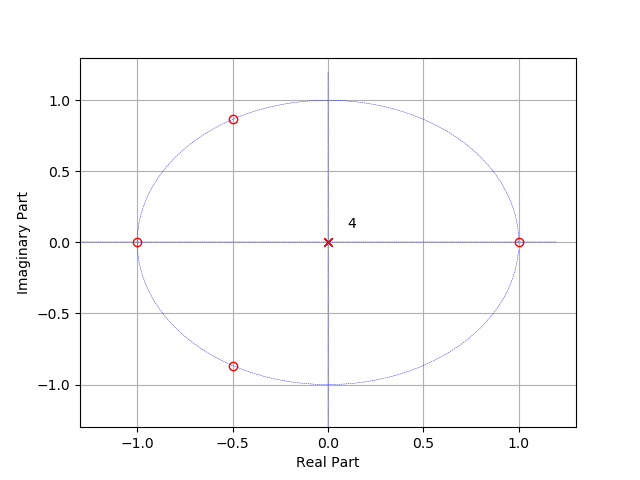

In [25]:
### tip-3 için kutup-sıfır diyagramı
num3 = np.array([1,1,0,-1,-1])
denum3 = np.array([1])
zplane.zplane(num3, denum3)
plt.show()

<IPython.core.display.Javascript object>


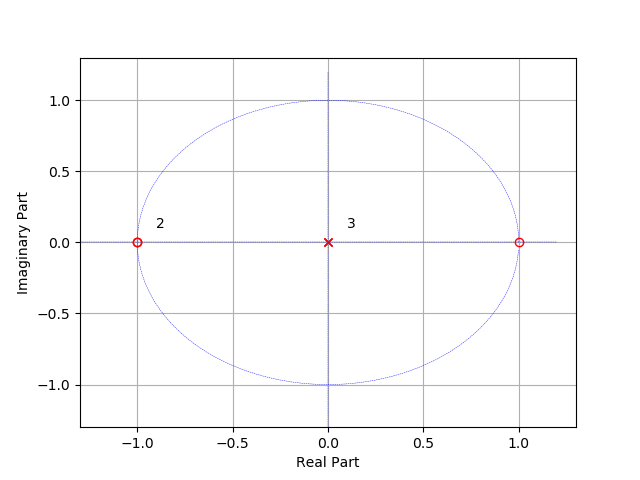

In [26]:
### tip-4 için kutup-sıfır diyagramı
num4 = np.array([1,1,-1,-1])
denum4 = np.array([1])
zplane.zplane(num4, denum4)
plt.show()

Öncelikle bu sistemler FIR yani sonlu olduklarından dolayı, sistemlerin kutupları yalnızca sonsuzdadır. Bu nedenle ROC sonsuz hariç her yerdir.

Tip-1'in kutup-sıfır diyagramını incelediğimizde, sıfırların bulunduğu noktalar frekansta sırasıyla yaklaşık olarak $0.4\pi$, $0.8\pi$, $-0.8\pi$ ve $-0.4\pi$ değerlerine karşılık gelmektedir. Genlik grafiğinden bu frekans değerlerini geçirmediği görülmektedir. Yani bu sonuç alçak geçiren filtre olma durumununu desteklemektedir.

Tip-2'nin kutup-sıfır diyagramını incelediğimizde, sıfırların bulunduğu noktalar frekansta sırasıyla yaklaşık olarak $\frac{1}{2}\pi$, $-\frac{1}{2}\pi$ ve $\pi$ değerlerine karşılık gelmektedir. Grafiği $[0,\pi]$ aralığında inceleyeceğimizden ( frekans uzayında en yüksek frekans $\pi$ ) $\pi/2$ ve $\pi$ frekansları bastırılmaktadır. Genlik grafiğinden bu frekans değerlerini geçirmediği görülmektedir. Yani bu sonuç alçak geçiren filtre olma durumununu desteklemektedir.

Tip-3'ün kutup-sıfır diyagramını incelediğimizde, sıfırların bulunduğu noktalar frekansta yaklaşık olarak $\pi$,  $0.67\pi$, $-0.67\pi$ ve $0$ değerlerine karşılık gelmektedir. Genlik grafiğinden bu frekans değerlerini geçirmediği görülmektedir. Yani bu sonuç band geçiren filtre olma durumununu desteklemektedir.

Tip-4'ün kutup-sıfır diyagramını incelediğimizde, sıfırların bulunduğu noktalar frekansta $0$ ve $\pi$ noktalarına karşılık gelmektedir. Bu frekansları bastırırsa kutup-sıfır diyagramından band geçiren filtre olacaığını söyleyebiliriz. Genlik grafiğinden bu frekans değerlerini geçirmediği görülmektedir. Yani bu sonuç band geçiren filtre olma durumununu desteklemektedir.

# SORU-2
FIR Tasarım

In [27]:
# to read .mat data file
from scipy.io import loadmat
filter_data_1 = loadmat("fır_lowpass_1_window.mat")      # load the filter obtained from pyfda
Coeffs1 = filter_data_1['ba'].astype(np.float)   # get the coefficients and convert them to float (from string)

b1 = Coeffs1[:,0]       # first column is b
a1 = np.array([1])      # second column is 1 for FIR filters
w1, Hw1 = sgnl.freqz(b1, a1)
Hw1_abs = np.abs(Hw1); Hw1_angle = np.unwrap(np.angle(Hw1))
tau1 = -np.diff(Hw1_angle)*(len(Hw1)/(2*pi))

<IPython.core.display.Javascript object>


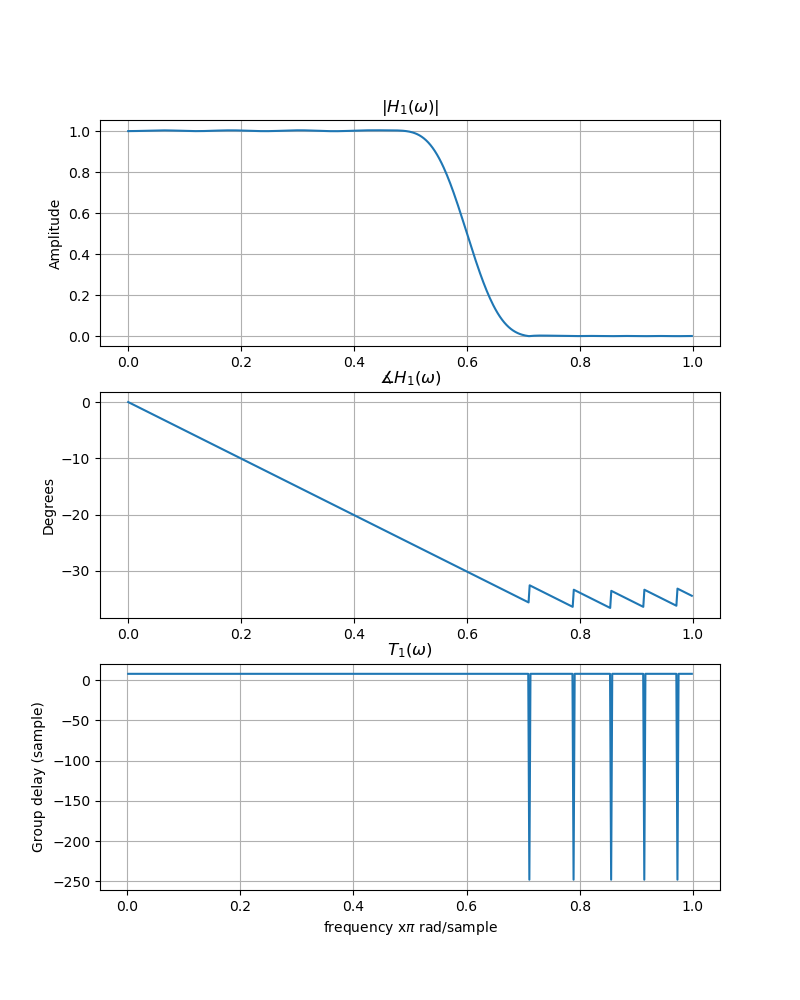

In [28]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(w1/pi, Hw1_abs); plt.title("$|H_{1}(\omega)|$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w1/pi, Hw1_angle); plt.title("$\measuredangle H_{1}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w1[1::]/pi, tau1); plt.title("$T_{1}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

In [29]:
filter_data_2 = loadmat("fır_lowpass_2_enqr.mat")      # load the filter obtained from pyfda
Coeffs2 = filter_data_2['ba'].astype(np.float)   # get the coefficients and convert them to float (from string)

b2 = Coeffs2[:,0]       # first column is b
a2 = np.array([1])      # second column is 1 for FIR filters
w2, Hw2 = sgnl.freqz(b2, a2)
Hw2_abs = np.abs(Hw2); Hw2_angle = np.unwrap(np.angle(Hw2))
tau2 = -np.diff(Hw2_angle)*(len(Hw2)/(2*pi))

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


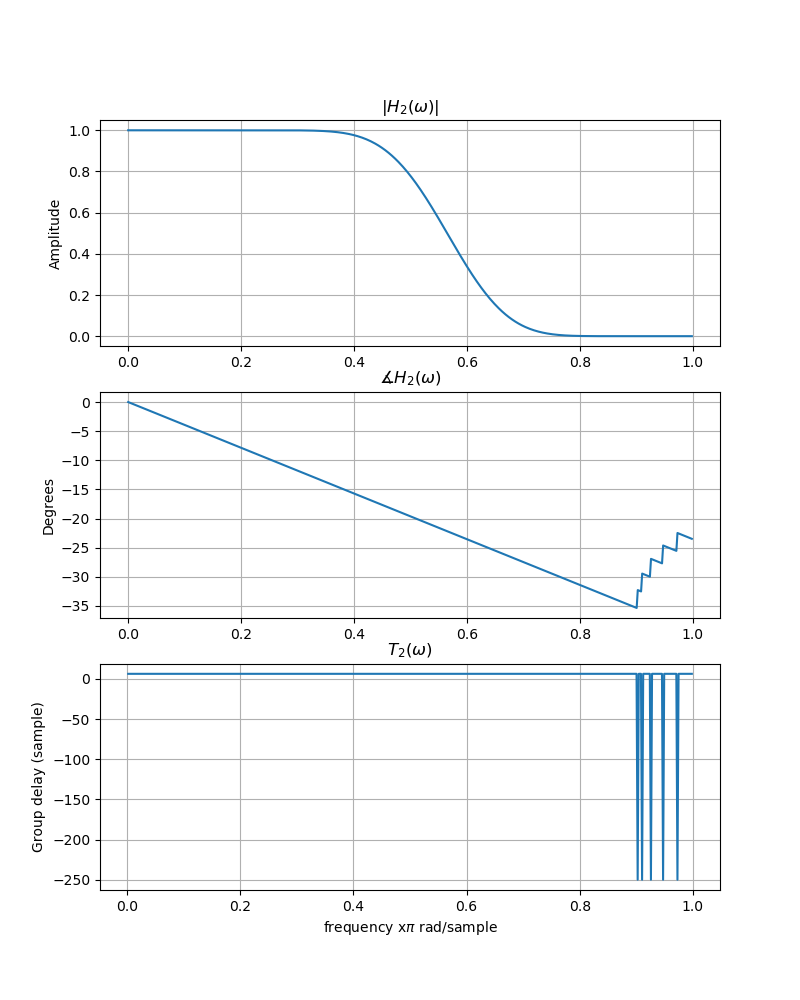

In [30]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(w2/pi, Hw2_abs); plt.title("$|H_{2}(\omega)|$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w2/pi, Hw2_angle); plt.title("$\measuredangle H_{2}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w2[1::]/pi, tau2); plt.title("$T_{2}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

In [31]:
filter_data_3 = loadmat("fır_bandpass_1_wind.mat")      # load the filter obtained from pyfda
Coeffs3 = filter_data_3['ba'].astype(np.float)   # get the coefficients and convert them to float (from string)

b3 = Coeffs3[:,0]       # first column is b
a3 = np.array([1])      # second column is 1 for FIR filters
w3, Hw3 = sgnl.freqz(b3, a3)
Hw3_abs = np.abs(Hw3); Hw3_angle = np.unwrap(np.angle(Hw3))
tau3 = -np.diff(Hw3_angle)*(len(Hw3)/(2*pi))

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


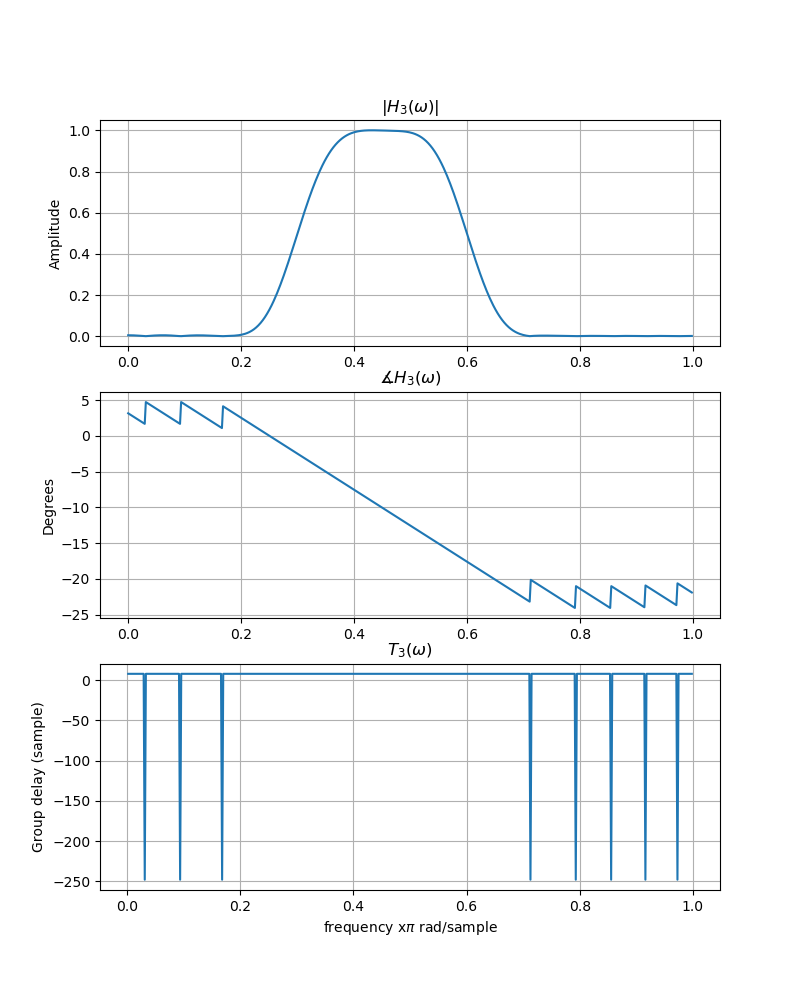

In [32]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(w3/pi, Hw3_abs); plt.title("$|H_{3}(\omega)|$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w3/pi, Hw3_angle); plt.title("$\measuredangle H_{3}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w3[1::]/pi, tau3); plt.title("$T_{3}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

In [33]:
filter_data_4 = loadmat("fır_bandpass_2_enqr.mat")      # load the filter obtained from pyfda
Coeffs4 = filter_data_4['ba'].astype(np.float)   # get the coefficients and convert them to float (from string)

b4 = Coeffs4[:,0]       # first column is b
a4 = np.array([1])      # second column is 1 for FIR filters
w4, Hw4 = sgnl.freqz(b4, a4)
Hw4_abs = np.abs(Hw4); Hw4_angle = np.unwrap(np.angle(Hw4))
tau4 = -np.diff(Hw4_angle)*(len(Hw4)/(2*pi))

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


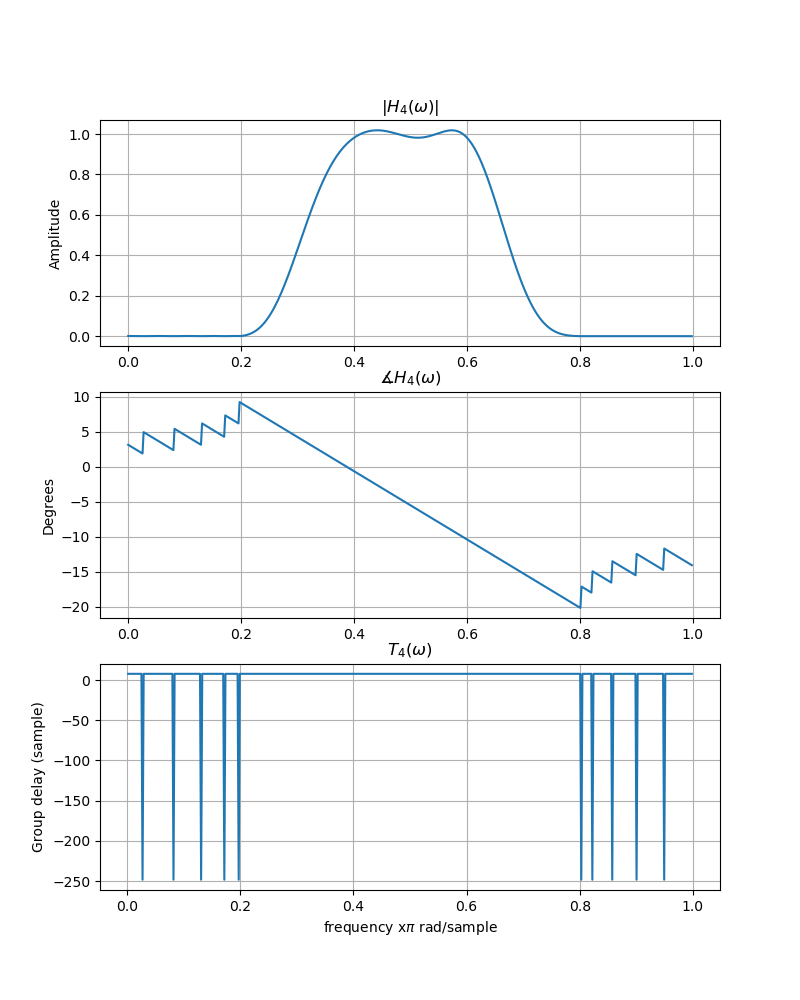

In [34]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(w4/pi, Hw4_abs); plt.title("$|H_{4}(\omega)|$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w4/pi, Hw4_angle); plt.title("$\measuredangle H_{4}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w4[1::]/pi, tau4); plt.title("$T_{4}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

Grafikleri incelediğimizde, FIR filtrelerin süreklilik sağlanan bölgelerde lineer faza ve dolayısıyla sabit grup gecikmesine sahip olduğu rahatlıkla görülmektedir.

Hamming ile oluşturulan agf daha hızlı azalma göstermektedir,bu da zaman domaininde daha çok gürültü bileşeni meydana gelceğini göstermektedir. Equiripple ile oluşturulan ise daha yavaş azalmaktadır, yani dürtü cevabında daha düşük yan lob seviyesine sahip olacaktır. Bu da zaman domaininde de daha az gürültü bileşeni meydana getirecektir.

Band geçiren filtre için equiripple ile oluşturulan filtrede geçiş bandında dalgaları görebiliyoruz.

# SORU-3
IIR tasarım

In [35]:
filter_data_5 = loadmat("ıır_cheby1_high.mat")      # load the filter obtained from pyfda
Coeffs5 = filter_data_5['ba'].astype(np.float)   # get the coefficients and convert them to float (from string)

b5 = Coeffs5[:,0]       # first column is b
a5 = Coeffs5[:,1]       # second column is b for IIR filters
w5, Hw5 = sgnl.freqz(b5, a5)
Hw5_abs = np.abs(Hw5); Hw5_angle = np.unwrap(np.angle(Hw5))
tau5 = -np.diff(Hw5_angle)*(len(Hw5)/(2*pi))

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


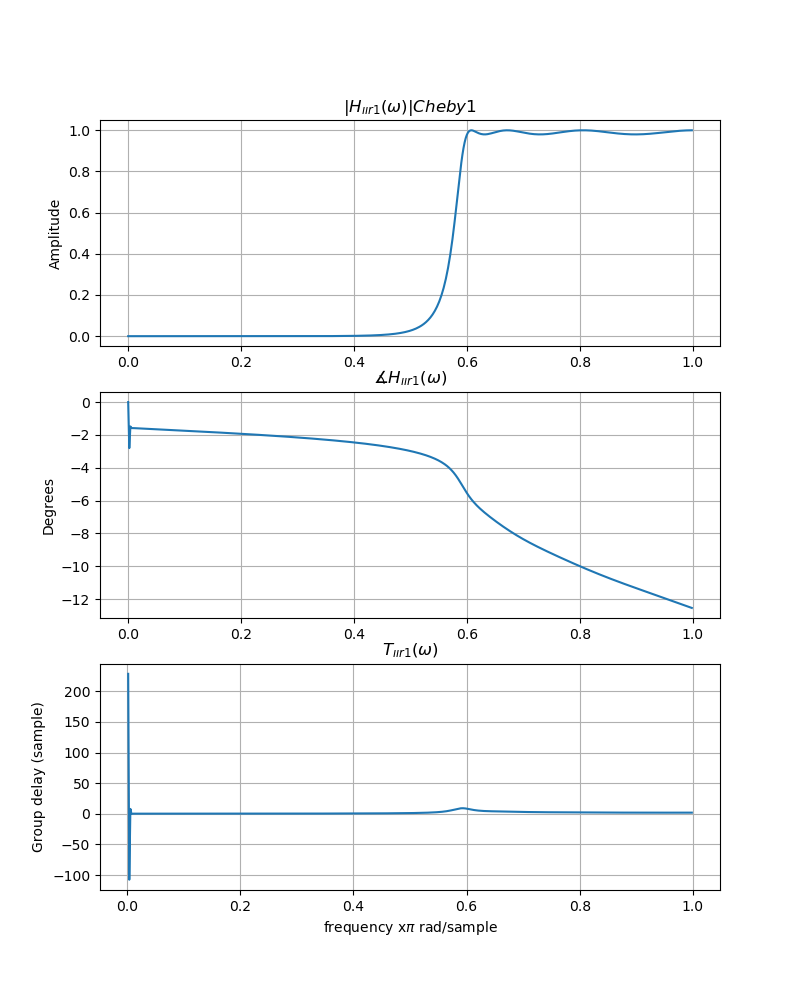

In [36]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(w5/pi, Hw5_abs); plt.title("$|H_{ıır1}(\omega)| Cheby1$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w5/pi, Hw5_angle); plt.title("$\measuredangle H_{ıır1}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w5[1::]/pi, tau5); plt.title("$T_{ıır1}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

In [37]:
filter_data_6 = loadmat("ıır_cheby1_low.mat")      # load the filter obtained from pyfda
Coeffs6 = filter_data_6['ba'].astype(np.float)   # get the coefficients and convert them to float (from string)

b6 = Coeffs6[:,0]       # first column is b
a6 = Coeffs6[:,1]       # second column is b for IIR filters
w6, Hw6 = sgnl.freqz(b6, a6)
Hw6_abs = np.abs(Hw6); Hw6_angle = np.unwrap(np.angle(Hw6))
tau6 = -np.diff(Hw6_angle)*(len(Hw6)/(2*pi))

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


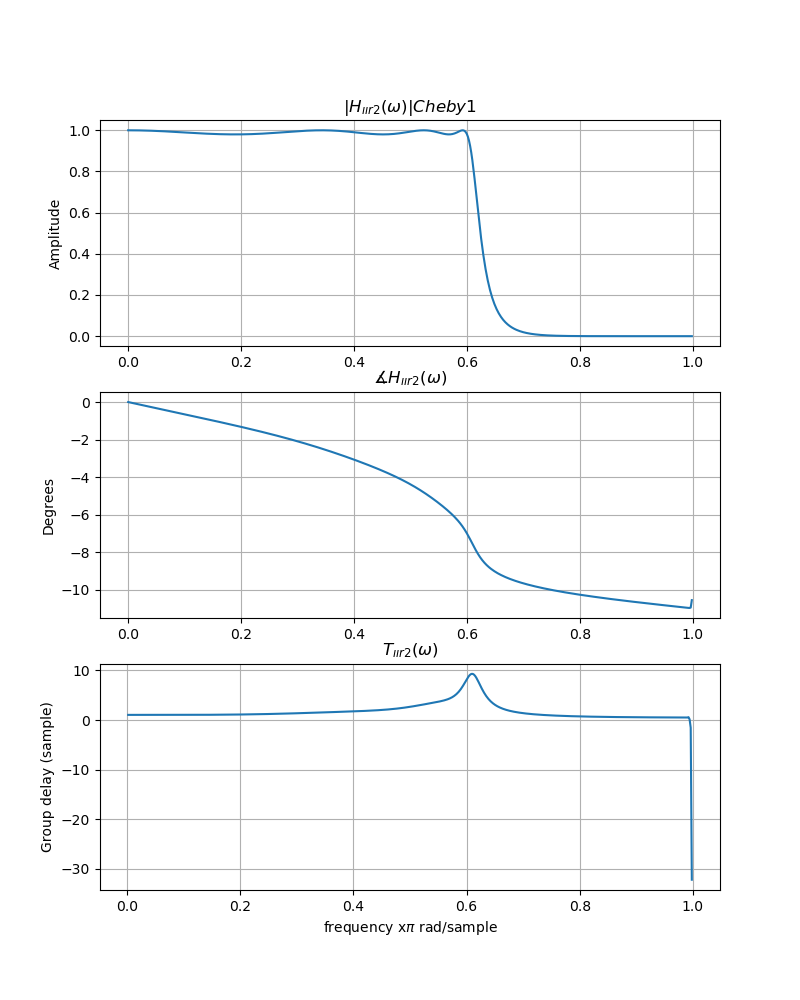

In [38]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(w6/pi, Hw6_abs); plt.title("$|H_{ıır2}(\omega)| Cheby1$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w6/pi, Hw6_angle); plt.title("$\measuredangle H_{ıır2}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w6[1::]/pi, tau6); plt.title("$T_{ıır2}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

In [39]:
filter_data_7 = loadmat("ıır_butter_high.mat")      # load the filter obtained from pyfda
Coeffs7 = filter_data_7['ba'].astype(np.float)   # get the coefficients and convert them to float (from string)

b7 = Coeffs7[:,0]       # first column is b
a7 = Coeffs7[:,1]       # second column is b for IIR filters
w7, Hw7 = sgnl.freqz(b7, a7)
Hw7_abs = np.abs(Hw7); Hw7_angle = np.unwrap(np.angle(Hw7))
tau7 = -np.diff(Hw7_angle)*(len(Hw7)/(2*pi))

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


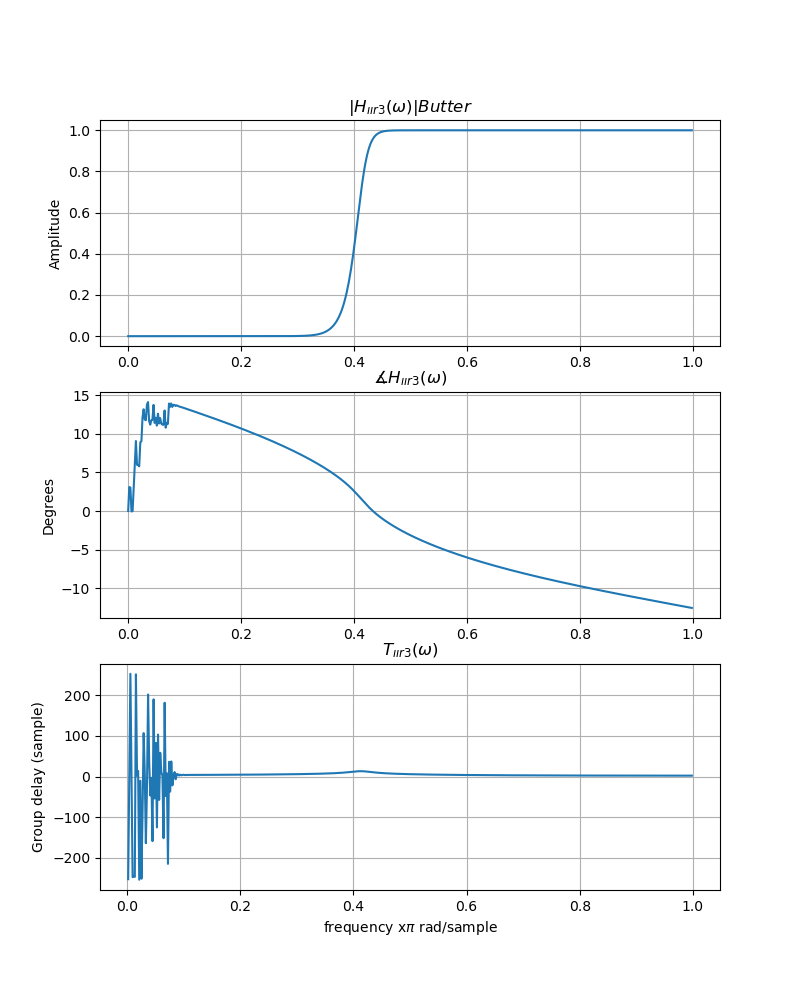

In [40]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(w7/pi, Hw7_abs); plt.title("$|H_{ıır3}(\omega)| Butter$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w7/pi, Hw7_angle); plt.title("$\measuredangle H_{ıır3}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w7[1::]/pi, tau7); plt.title("$T_{ıır3}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

In [41]:
filter_data_8 = loadmat("ıır_butter_low.mat")      # load the filter obtained from pyfda
Coeffs8 = filter_data_8['ba'].astype(np.float)   # get the coefficients and convert them to float (from string)

b8 = Coeffs8[:,0]       # first column is b
a8 = Coeffs8[:,1]       # second column is b for IIR filters
w8, Hw8 = sgnl.freqz(b8, a8)
Hw8_abs = np.abs(Hw8); Hw8_angle = np.unwrap(np.angle(Hw8))
tau8 = -np.diff(Hw8_angle)*(len(Hw8)/(2*pi))

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


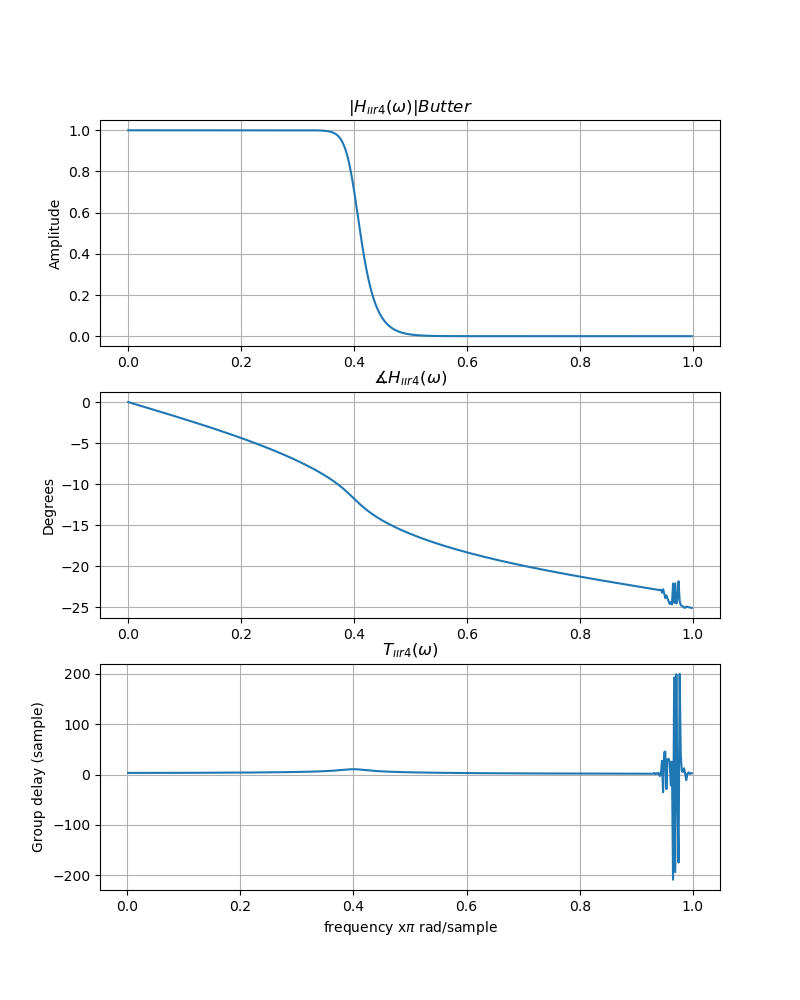

In [42]:
plt.figure(figsize=(8,10))
plt.subplot(311)
plt.plot(w8/pi, Hw8_abs); plt.title("$|H_{ıır4}(\omega)| Butter$")
plt.ylabel("Amplitude"); plt.grid("on")
plt.subplot(312)
plt.plot(w8/pi, Hw8_angle); plt.title("$\measuredangle H_{ıır4}(\omega)$")
plt.ylabel("Degrees"); plt.grid("on")
plt.subplot(313)
plt.plot(w8[1::]/pi, tau8); plt.title("$T_{ıır4}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Group delay (sample)")
plt.grid("on")
plt.show()

Grafiklerden görüldüğü üzere IIR filtrelerin fazı lineer değildir ve sonuç olarak grup gecikmesi de sabit sayı değildir. Filtrenin derecesi küçük olsa da istenmeyen frekansları bastırma açısından FIR filtrelerden daha iyi sonuç vermektedir.

# SORU-4 

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


<IPython.core.display.Javascript object>


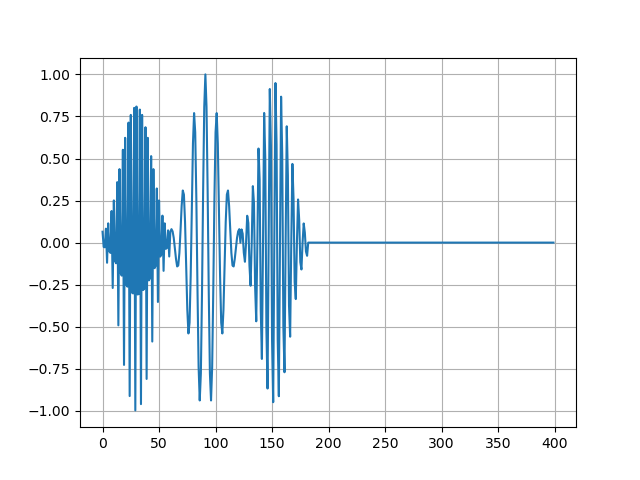

In [43]:
# xn işaretini tanımladık:
# Generate the individual components and the input signal
N = 400      # total number of samples in the input signal
M = 60       # size of the window function (and sample length of the frequency components)
n1 = np.arange(0, M+1, 1)   # index vector of M+1 points
wn = 0.54 - 0.46*np.cos(2*pi*n1/M)      # window function (Hamming window)

# the components
x1 = wn*np.cos(0.2*pi*n1)               # component with w1 = 0.2*pi frequency
x2 = wn*np.cos(0.4*pi*n1 - pi/2)     # component with w1 = 0.4*pi frequency
x3 = wn*np.cos(0.8*pi*n1 - pi/5)     # component with w1 = 0.8*pi frequency

xn = np.concatenate((x3, x1, x2, np.zeros(N-3*len(n1))), axis=None)

plt.figure()
plt.plot(xn)
plt.grid("on")
plt.show()

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


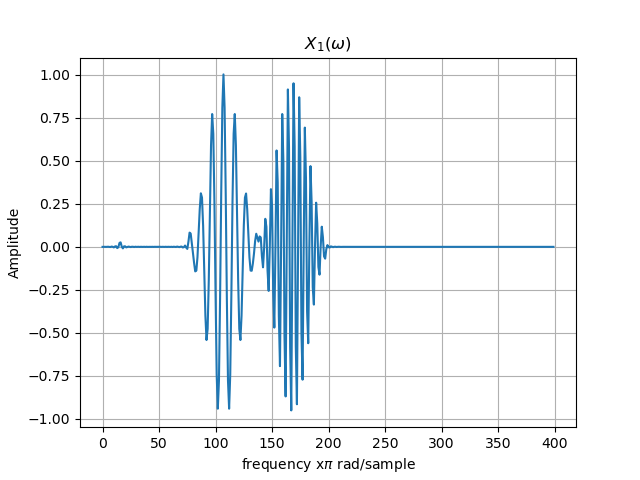

In [44]:
yn1 = sgnl.lfilter(b1, a1, xn)          # using the coefficients, we applied the signal to the input of the filter.

plt.figure()
plt.plot(yn1); plt.title("$X_{1}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Amplitude")
plt.grid("on")
plt.show()

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


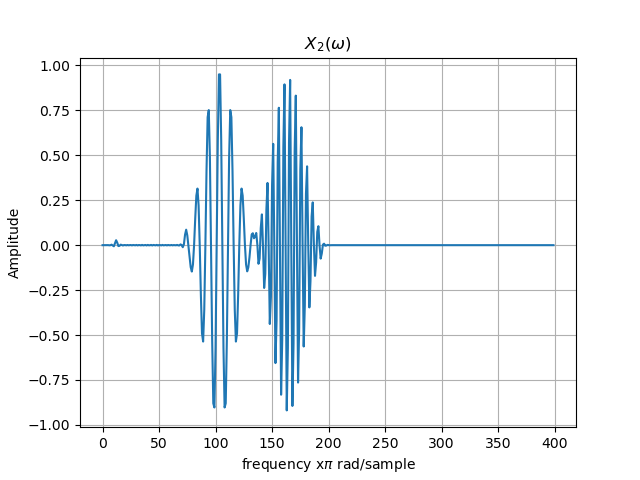

In [45]:
yn2 = sgnl.lfilter(b2, a2, xn)          # using the coefficients, we applied the signal to the input of the filter.

plt.figure()
plt.plot(yn2); plt.title("$X_{2}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Amplitude")
plt.grid("on")
plt.show()

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


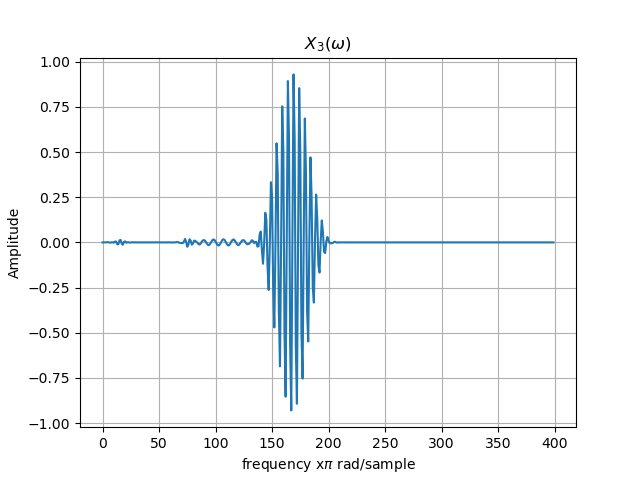

In [46]:
yn3 = sgnl.lfilter(b3, a3, xn)          # using the coefficients, we applied the signal to the input of the filter.

plt.figure()
plt.plot(yn3); plt.title("$X_{3}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Amplitude")
plt.grid("on")
plt.show()

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


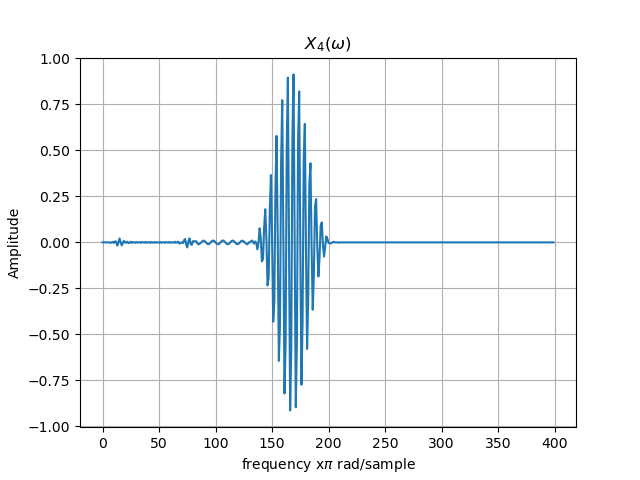

In [47]:
yn4 = sgnl.lfilter(b4, a4, xn)          # using the coefficients, we applied the signal to the input of the filter.

plt.figure()
plt.plot(yn4); plt.title("$X_{4}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Amplitude")
plt.grid("on")
plt.show()

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


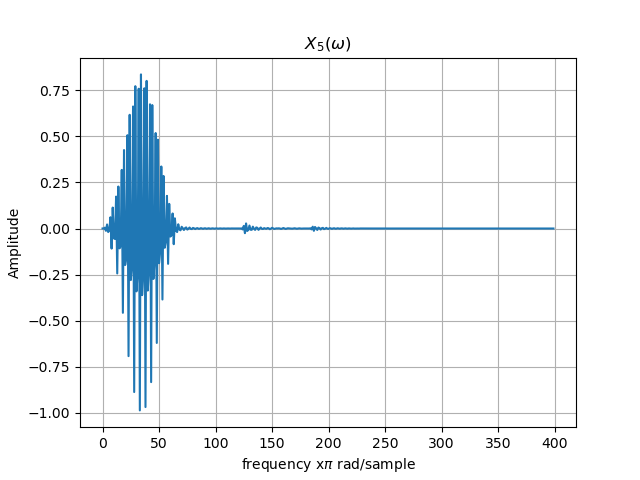

In [48]:
## IIR filtreler
yn5 = sgnl.lfilter(b5, a5, xn)          # using the coefficients, we applied the signal to the input of the filter.

plt.figure()
plt.plot(yn5); plt.title("$X_{5}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Amplitude")
plt.grid("on")
plt.show()

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


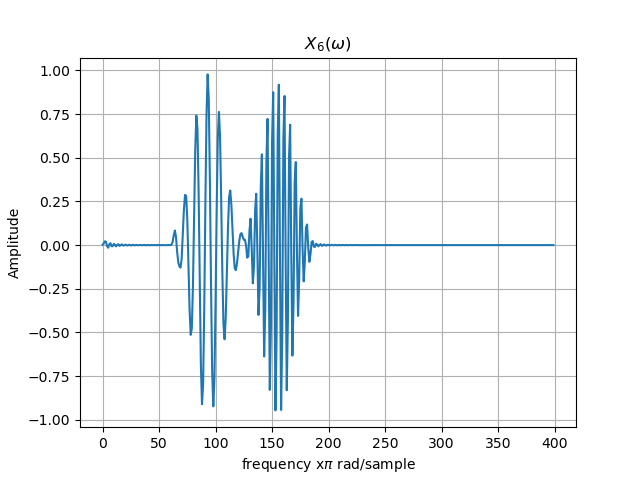

In [49]:
## IIR filtreler
yn6 = sgnl.lfilter(b6, a6, xn)          # using the coefficients, we applied the signal to the input of the filter.

plt.figure()
plt.plot(yn6); plt.title("$X_{6}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Amplitude")
plt.grid("on")
plt.show()

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


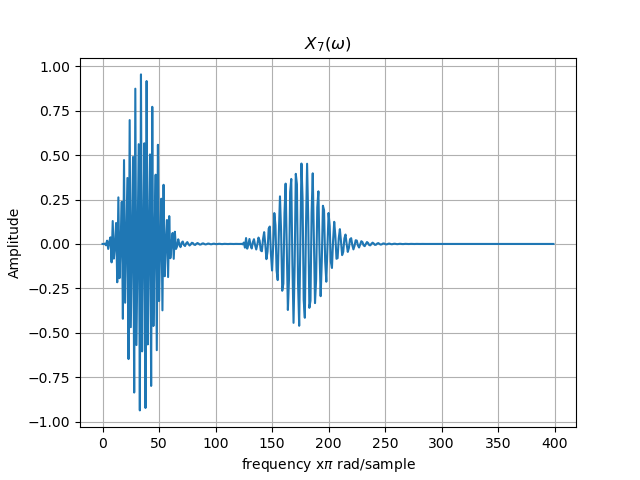

In [50]:
## IIR filtreler
yn7 = sgnl.lfilter(b7, a7, xn)          # using the coefficients, we applied the signal to the input of the filter.

plt.figure()
plt.plot(yn7); plt.title("$X_{7}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Amplitude")
plt.grid("on")
plt.show()

c:\users\asus\anaconda3\envs\tf15\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


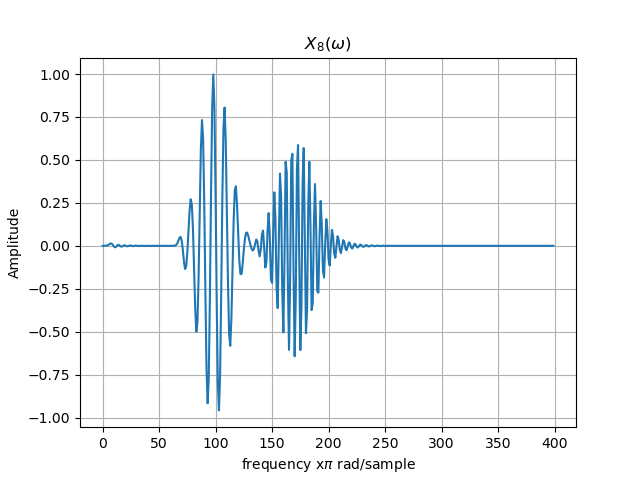

In [51]:
## IIR filtreler
yn8 = sgnl.lfilter(b8, a8, xn)          # using the coefficients, we applied the signal to the input of the filter.

plt.figure()
plt.plot(yn8); plt.title("$X_{8}(\omega)$")
plt.xlabel('frequency x$\pi$ rad/sample'); plt.ylabel("Amplitude")
plt.grid("on")
plt.show()

Grafikleri sırasıyla incelediğimizde x[n] işaretinde soldan sağa $0.8\pi$, $0.2\pi$ ve $0.4\pi$ frekanslı sinyaller bulunur.

İlk grafikteki FIR filtresi hamming tipiyle tasarlanan agf'dir. Grafikte görüldüğü üzere $0.8\pi$ frekansındaki işaret çıkışta gözükmemiştir. Grup gecikmesi sabit olduğundan dolayı çıkıştaki işaretlerde kayma olsa bile aynı sayıda kayma olmaktadır. Bu uyguladığımız tüm FIR filtreler için geçerlidir. Bu nedenle FIR filtrelerinin çıkışındaki işaretlerde bozulma görmemekteyiz.

İkinci grafikte equiripple tipinde agf FIR filtresi uygulandı, çıkışta beklediğimiz gibi $0.8\pi$ deki işaret filtrelenmiştir.

Üçüncü grafikte FIR filtresi hamming tipiyle tasarlanan band geçiren filtredir. Grafikte de görüldüğü üzere beklediğimiz gibi yalnızca $0.4\pi$ frekansındaki sinyali geçirmiştir. 

Dördüncü grafik ise equiripple ile tasarlanan band geçiren FIR filtresidir. N değeri daha küçüktür ve görüldüğü gibi daha yavaş azalmıştır, diğer frekans bileşenleri üçüncüde daha az gözlenmektedir. Geçmesini istemediğimiz frekans değerleri üçüncüye göre, az miktar da olsa, grafikte gözlenmektedir. Çıkışta beklendiği gibi yalnızca $0.4\pi$ frekanslı işaret görülmektedir

#### IIR filtreler için oluşturacağımız filtreler lineer faza sahip değildir dolayısıyla grup gecikmesi de sabit olmayacaktır. Bu da çıkış işaretinde her frekansın aynı miktarda gecikmeyeceğini gösterir. Yani çıkıştaki işaretlerimizde bozulma olabilmektedir.

Beşinci grafikte, cheby1 tipinde IIR hpf uygulanmıştır. İşaretin genliğinde filtreleme sonucunda oluşabilecek olan hafif miktarda bir azalma gözlenmiştir, bu azalma tüm tip filtrelerde meydana gelebilir. Grafikte de görüldüğü üzere yalnızca $0.8\pi$ frekanslı bileşen filtreden geçmiştir. FIR filtrelere göre, diğer frekanslar daha iyi bastırılmıştır.

Altıncı grafikte cheby1 tipinde IIR agf uygulanmıştır. Çıkışta beklendiği üzere $0.2\pi$ ve $0.4\pi$ frekanslı bileşenler görülmektedir. Fakat iki işaretin birleştiği noktada, x ekseninin yaklaşık 120 ile 130 olduğu noktada, iki işaretin de biraz bozulduğu gözlenmektedir. Bunun sebebi IIR filtre tiplerinin sabit grup gecikmesine sahip olmamasından kaynaklıdır.

Yedinci grafikte Butterworth tipinde IIR hpf uygulanmıştır. Grafiklerde $0.4\pi$ ve $0.8\pi$ frekanslı bileşenlerin geçtiği görülmektedir. Fakat iki işarette gönderilen şeklinden farklıdır. 

Sekizinci grafikte Butterworth tipinde IIR agf uygulanmıştır. Grafiklerde $0.2\pi$ ve $0.4\pi$ frekansındaki bileşenlerin geçtiği rahatça görülebilir. Fakat $0.4\pi$ frekansındaki işaretimizde bozulma meydana gelmiştir.

Grafikleri oluşturma sürecinde FIR filtrelerin işareti bozmadığını fakat istemediğimiz frekansları az da olsa çıkışta gösterdiğini gözlemledim. Buna karşılık IIR filtreler ise istediğimiz frekansları daha az derece ile elde etmektedir. Aynı n değeri için IIR frekanslar daha iyi filtreleme gerçekleştirir. Fakat IIR filtreler sabit grup gecikmesine sahip olmadığı için çıkıştaki işaretimizi bozabilmektedir.